Import

In [1]:
import os
os.chdir('..')

from Src.config import configuration
cfg = configuration.config_manager().get_path()

print(cfg)



folder : c:\Users\yanni\Documents\Projects\Pred_maint_projects
[2024-03-19 22:08:03,979: INFO: common: yaml file: Config\path.yaml loaded successfully]
[2024-03-19 22:08:03,981: INFO: common: created directory at: workdir]
[2024-03-19 22:08:03,982: INFO: common: created directory at: workdir/model]
{'config_path': {'work_dir': 'workdir', 'model_dir': 'workdir/model', 'local_data_file': 'data/predictive_maintenance.csv', 'local_data_file_analyse': 'workdir/predictive_maintenance_A.csv', 'local_data_file_validation': 'workdir/predictive_maintenance_validation.csv', 'local_data_file_train': 'workdir/predictive_maintenance_train.csv', 'local_data_file_test': 'workdir/predictive_maintenance_test.csv'}}


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from Src.utils.Visualize import utils_visualize as viz

In [3]:
import warnings

warnings.filterwarnings(action='ignore')

Read data

In [4]:
df = pd.read_csv(cfg.config_path.local_data_file, index_col='UDI')
df.head()

Product ID Type  Air temperature [K]  Process temperature [K]  \
UDI                                                                 
1       M14860    M                298.1                    308.6   
2       L47181    L                298.2                    308.7   
3       L47182    L                298.1                    308.5   
4       L47183    L                298.2                    308.6   
5       L47184    L                298.2                    308.7   

     Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
UDI                                                                             
1                      1551         42.8                0       0   No Failure  
2                      1408         46.3                3       0   No Failure  
3                      1498         49.4                5       0   No Failure  
4                      1433         39.5                7       0   No Failure  
5                      1408         40.0                9       0   No Failure

In [6]:
df.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]        Target  
count  10000.000000     10000.000000  10000.000000  
mean      39.986910       107.951000      0.033900  
std        9.968934        63.654147      0.180981  
min        3.800000         0.000000      0.000000  
25%       33.200000        53.000000      0.000000  
50%       40.100000       108.000000      0.000000  
75%       46.800000       162.000000      0.000000  
max       76.600000       253.000000      1.000000

Delete the 'Product ID' columns

In [9]:
df.drop(columns=['Product ID'], inplace=True)

Compute difference between 'Process temperature' and 'Air temperature'

In [10]:
df['Difference temperature [K]'] = df['Process temperature [K]'] - df['Air temperature [K]']

Compute the power of system

In [11]:
df['Power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

## Analyse dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Type                        10000 non-null  object 
 1   Air temperature [K]         10000 non-null  float64
 2   Process temperature [K]     10000 non-null  float64
 3   Rotational speed [rpm]      10000 non-null  int64  
 4   Torque [Nm]                 10000 non-null  float64
 5   Tool wear [min]             10000 non-null  int64  
 6   Target                      10000 non-null  int64  
 7   Failure Type                10000 non-null  object 
 8   Difference temperature [K]  10000 non-null  float64
 9   Power                       10000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 859.4+ KB


No missing values in the different columns.
different kind of type of features

In [13]:
df.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]        Target  \
count  10000.000000     10000.000000  10000.000000   
mean      39.986910       107.951000      0.033900   
std        9.968934        63.654147      0.180981   
min        3.800000         0.000000      0.000000   
25%       33.200000        53.000000      0.000000   
50%       40.100000       108.000000      0.000000   
75%       46.800000       162.000000      0.000000   
max       76.600000       253.000000      1.000000   

       Difference temperature [K]         Power  
count                10000.000000  10000.000000  
mean                    10.000630  59967.147040  
std                      1.001094  10193.093881  
min                      7.600000  10966.800000  
25%                      9.300000  53105.400000  
50%                      9.800000  59883.900000  
75%                     11.000000  66873.750000  
max                     12.100000  99980.400000

In [14]:
df.isna().sum()

Type                          0
Air temperature [K]           0
Process temperature [K]       0
Rotational speed [rpm]        0
Torque [Nm]                   0
Tool wear [min]               0
Target                        0
Failure Type                  0
Difference temperature [K]    0
Power                         0
dtype: int64

Compute duplicate data

In [15]:
df.duplicated().sum()

0

Plot repartition of data 'Target'

[2024-01-20 18:35:52,213: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-20 18:35:52,232: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


Target
0    9661
1     339
Name: count, dtype: int64

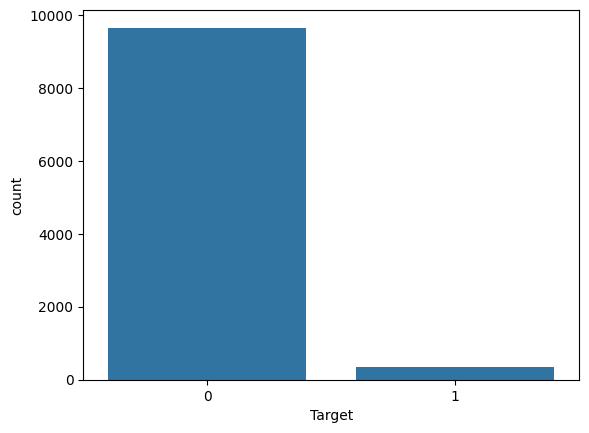

In [16]:
sns.countplot(x='Target', data=df)
df['Target'].value_counts()

Plot repartition of 'Failure Type' feature when 'Target' is True

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Power Failure'),
  Text(1, 0, 'Tool Wear Failure'),
  Text(2, 0, 'Overstrain Failure'),
  Text(3, 0, 'No Failure'),
  Text(4, 0, 'Heat Dissipation Failure')])

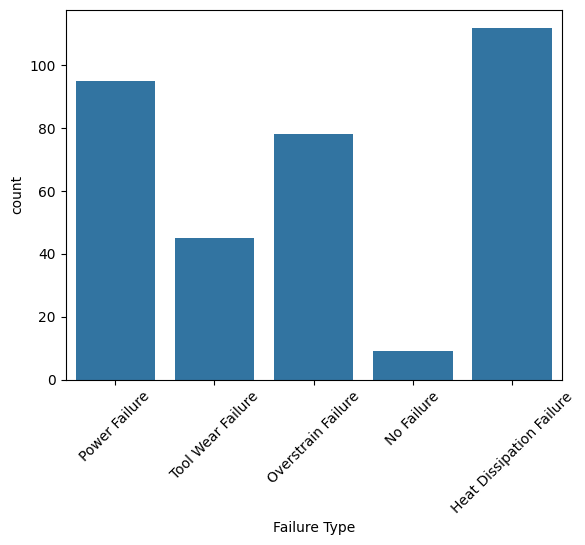

In [14]:
sns.countplot(x='Failure Type', data=df[df['Target']==1])
df['Failure Type'].value_counts()
plt.xticks(rotation=45)

Define fonction for display repartition for each feature

[2024-01-18 22:05:19,010: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 22:05:19,027: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 22:05:19,063: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 22:05:19,063: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 22:05:19,101: INFO: category: Using categorical units to

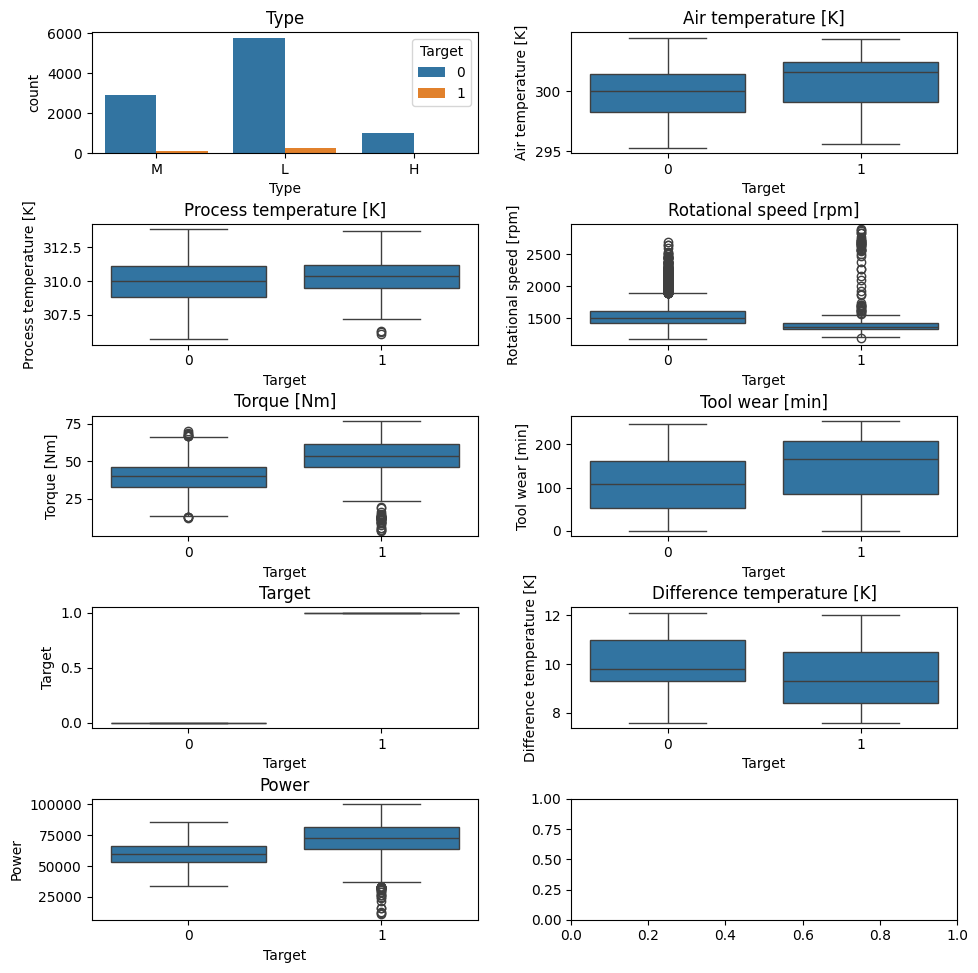

In [15]:

        
viz.visualize_box(df.drop(columns=[ 'Failure Type']),'Target', 2)

[2024-01-18 21:55:09,996: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 21:55:10,009: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 21:55:10,096: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 21:55:10,117: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-01-18 21:55:10,201: INFO: category: Using categorical units to

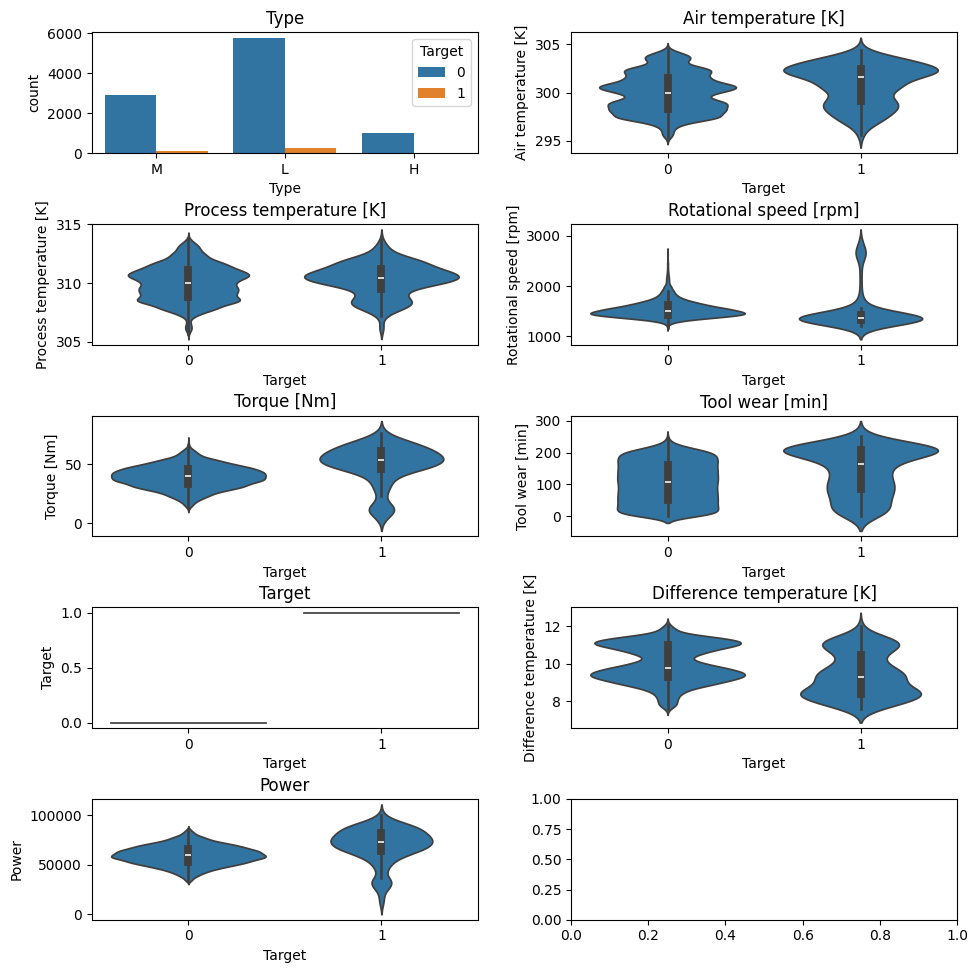

In [16]:

# Call the visualize_violon function with the specified parameters
viz.visualize_violon(df.drop(columns=[ 'Failure Type']),'Target', 2)

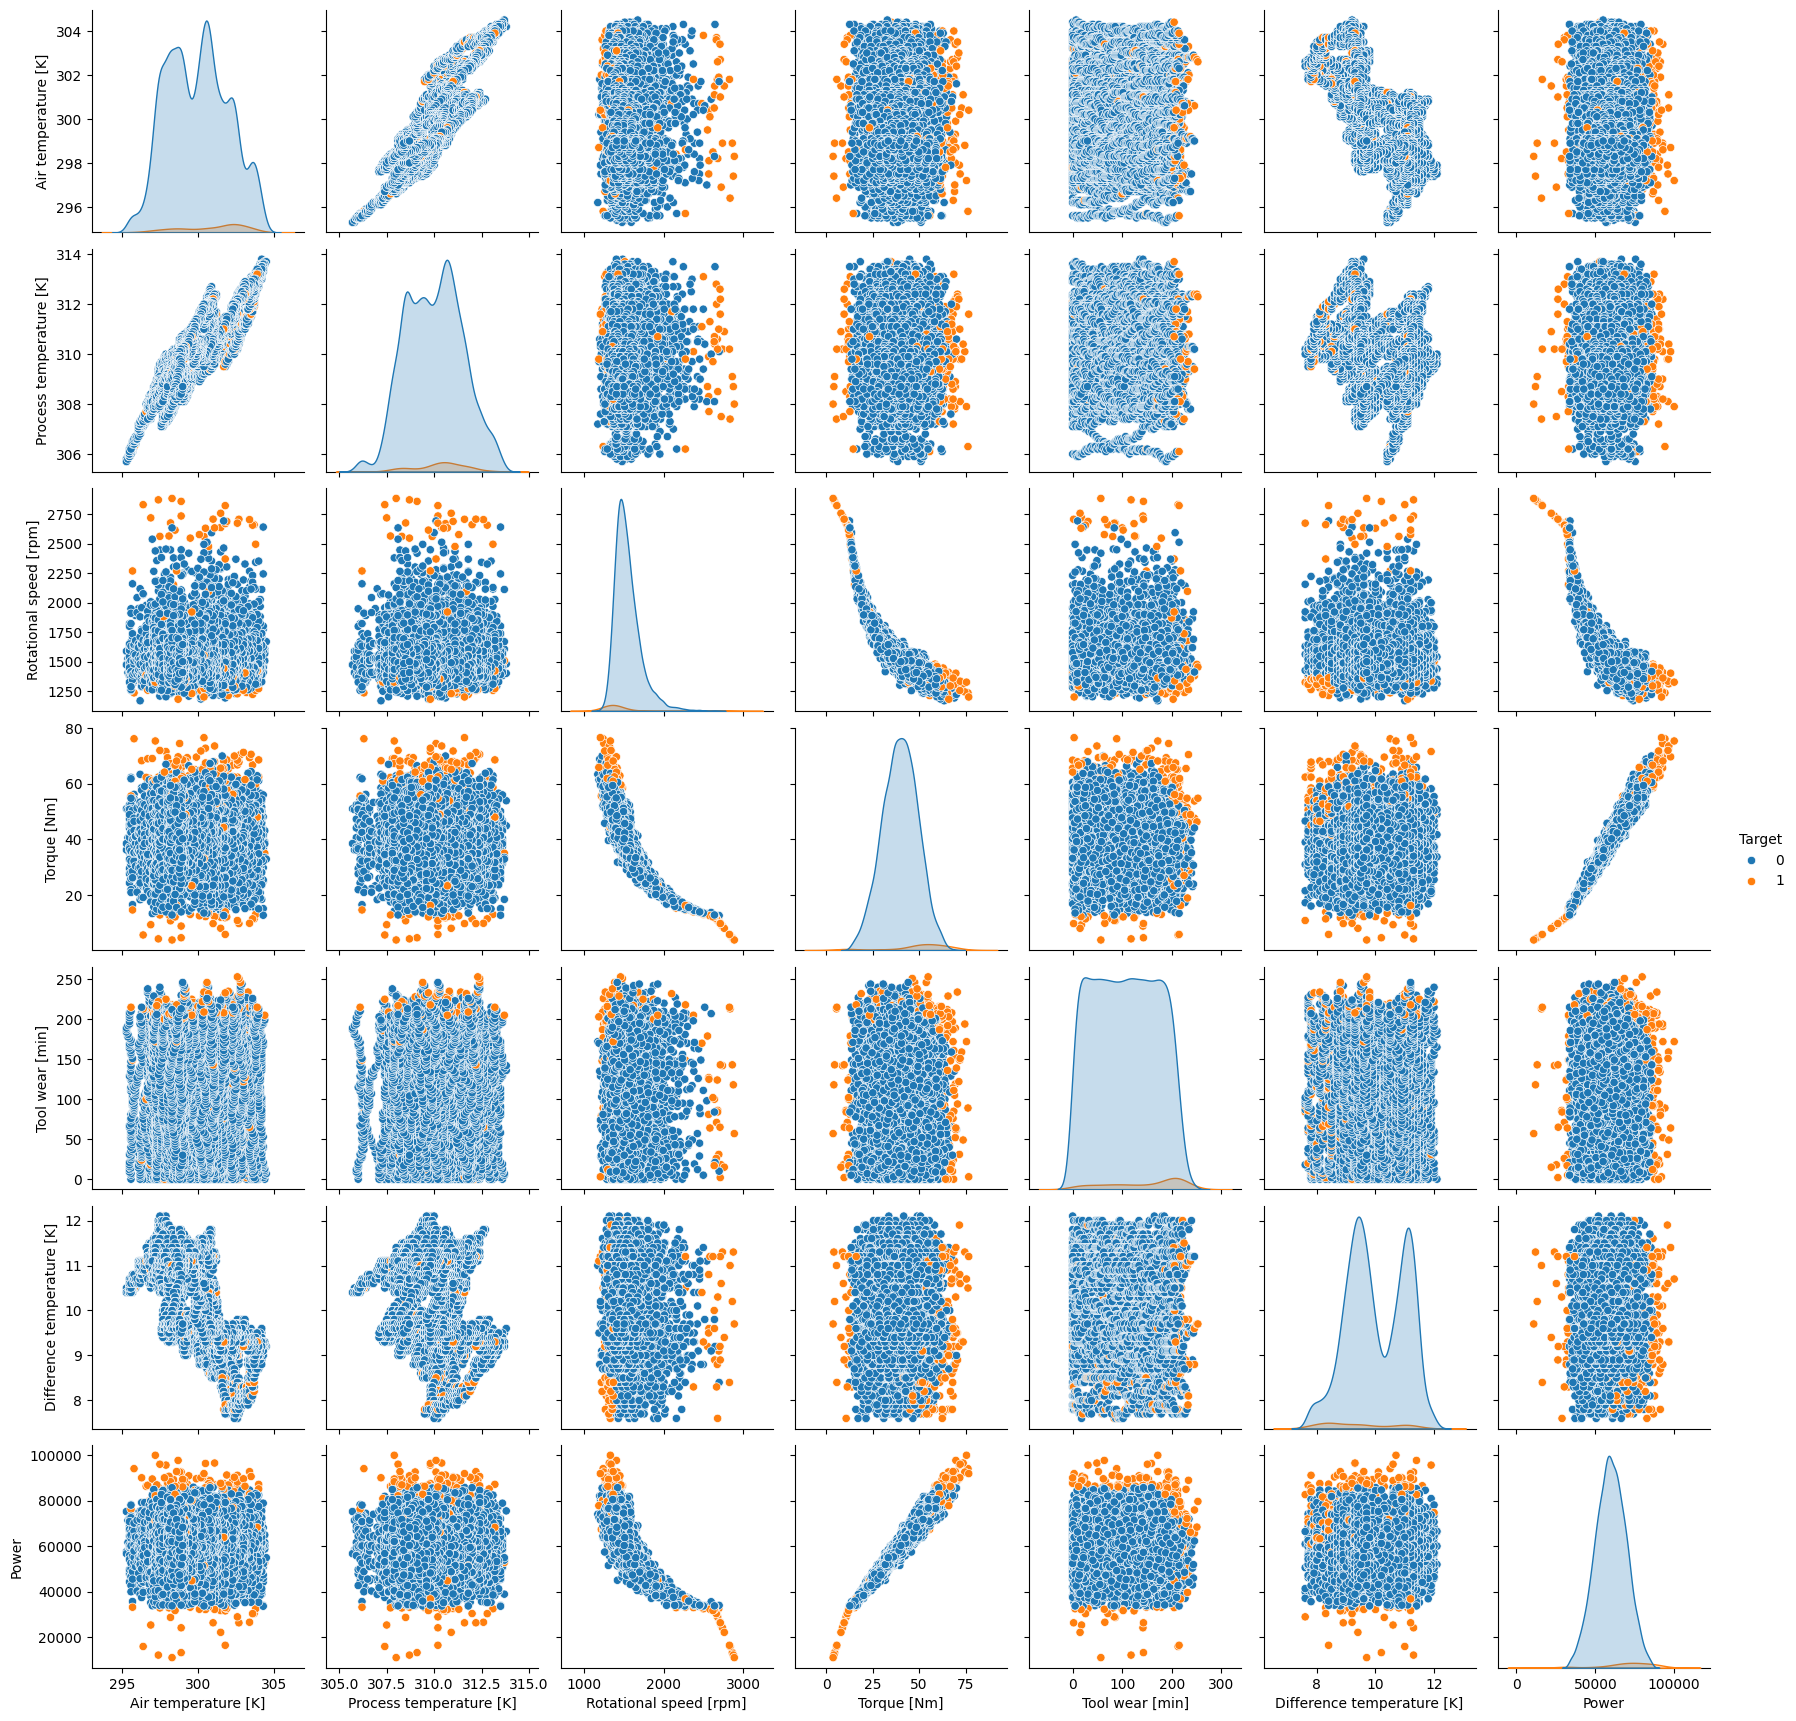

In [17]:
sns.pairplot(df, hue='Target')


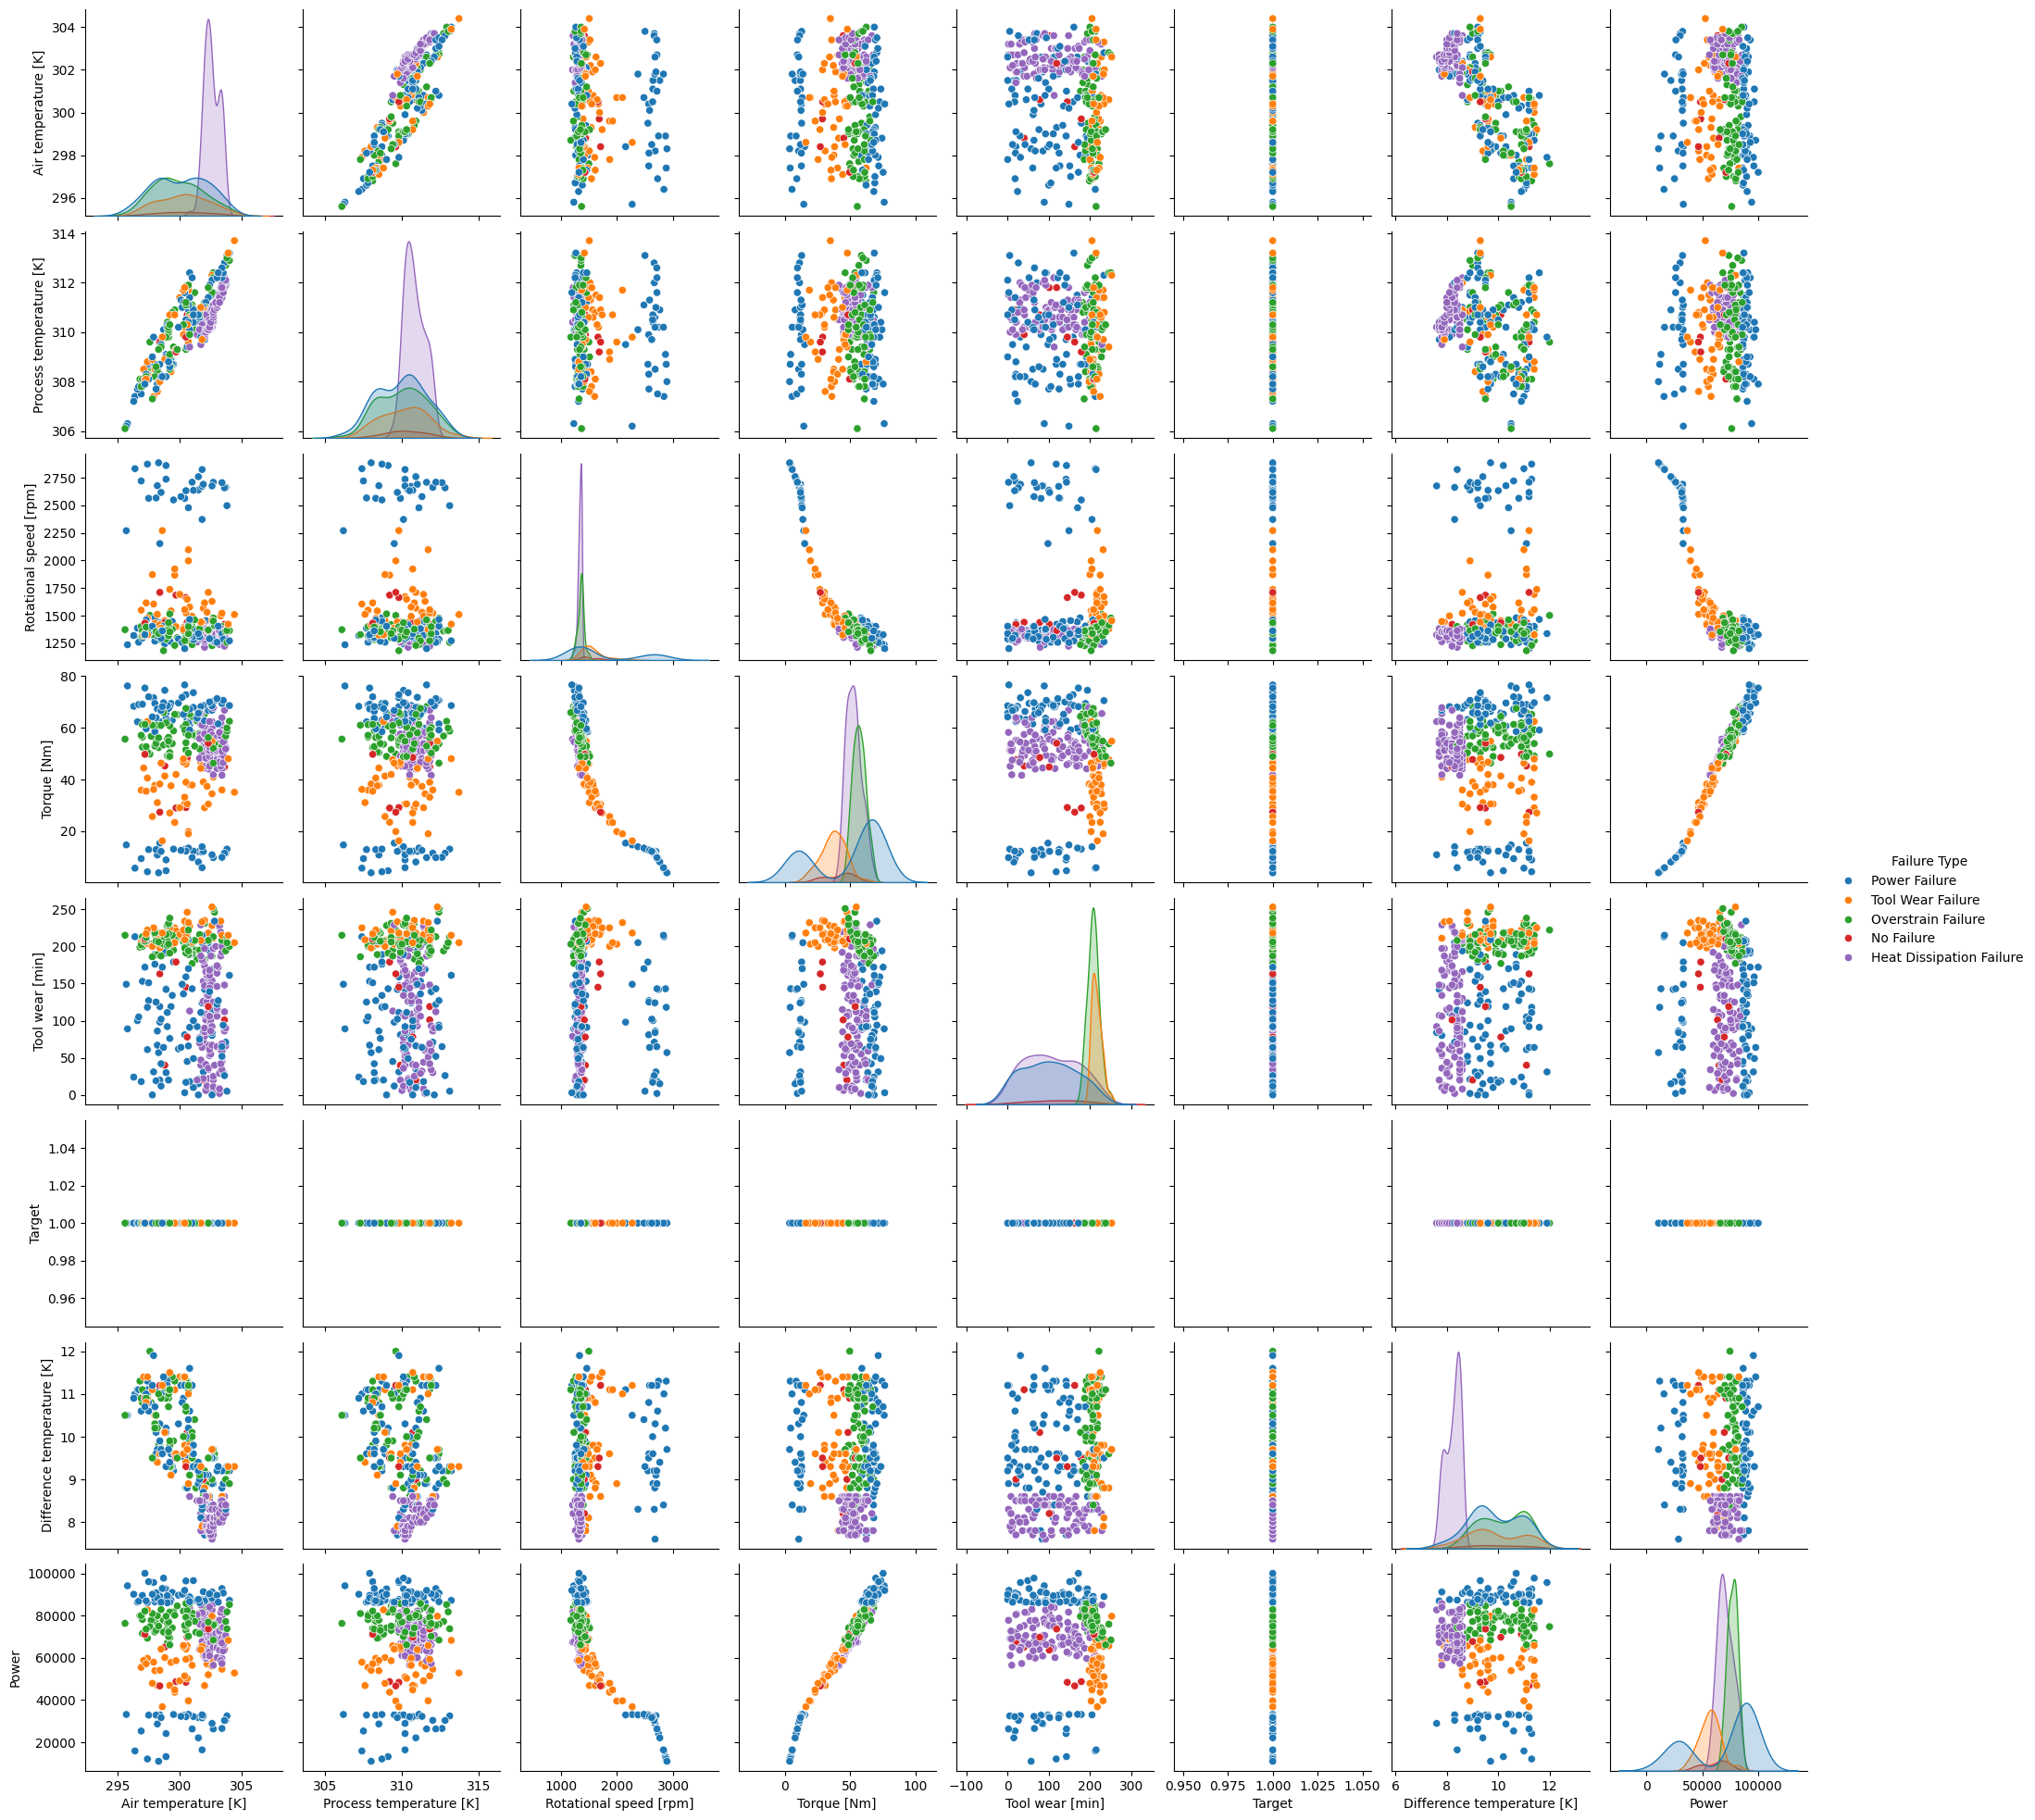

In [18]:
sns.pairplot(df[df['Target']==1], hue='Failure Type')

In [18]:
df.to_csv(cfg.config_path.local_data_file_analyse)